# Exercise 1: Quantifying KV Cache Memory Growth

**Goal:** Empirically measure and analyze the growth in peak GPU memory consumption during LLM inference as the number of generated tokens increases. This will help us quantify the memory footprint of the Key-Value (KV) Cache.

**Key Learning:** Understand the direct, linear relationship between sequence length and the memory required for the KV Cache, and appreciate this as a critical trade-off in LLM inference.

---

## Step 1: Setup and Environment

In [ ]:
import os
import torch
import time
from transformers import AutoModelForCausalLM, AutoTokenizer
import gc
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## Step 2: Configuration and Model Loading

We'll define our configurations: the model we want to test, the device, and the different generation lengths we want to measure.

In [ ]:
os.environ["HF_HUB_OFFLINE"] = "1"
model_name = "/voc/shared/models/llama/Llama-3.2-1B"

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if device == "cuda" and torch.cuda.is_bf16_supported() else torch.float32

prompt = "The best way to optimize LLM inference is"
# We will test memory usage for generating various numbers of new tokens.
generation_lengths = [50, 100, 200, 300, 400]

print(f"Using device: {device}, dtype: {dtype}")
if device != "cuda":
    print("Warning: This exercise is best run on a CUDA GPU for accurate memory measurement.")

Using device: cuda, dtype: torch.float32


Next, we define a helper function to get the peak memory usage and then load our model and tokenizer.

In [5]:
def get_peak_memory_mb(device=None):
    """Gets the peak memory usage on a given CUDA device in megabytes."""
    if device is None:
        device = torch.cuda.current_device()
    return torch.cuda.max_memory_allocated(device) / (1024 * 1024)

print(f"Loading model and tokenizer for {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=dtype,
).to(device)
model.eval()
print("Model and tokenizer loaded.")

# Store results here
peak_memory_results_mb = []

Loading model and tokenizer for meta-llama/Llama-3.2-1B...
Model and tokenizer loaded.


## Step 3: Measuring Memory Growth

This is the core of our experiment. We will loop through each of our specified `generation_lengths`. In each iteration, we will:
1. **Reset Memory Stats:** Use `torch.cuda.reset_peak_memory_stats()` to clear the memory counter. This is crucial for isolating the memory usage of each specific `model.generate()` call.
2. **Generate Text:** Run `model.generate()` with `use_cache=True`.
3. **Record Peak Memory:** Immediately after generation, record the peak memory usage for that run.
4. **Clean Up:** Clear the generated tensors to ensure each run is as independent as possible.

In [6]:
# First, get a baseline memory measurement *after* the model is loaded.
if device == "cuda":
    torch.cuda.synchronize()
    baseline_memory_mb = get_peak_memory_mb()
    print(f"Baseline peak memory (model loaded): {baseline_memory_mb:.2f} MB")

for length in generation_lengths:
    print(f"\nGenerating {length} new tokens...")
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Reset peak memory stats right before the generation call
    if device == "cuda":
        torch.cuda.reset_peak_memory_stats()

    # Generate text, which will populate the KV cache
    with torch.no_grad():
        model.generate(
            inputs["input_ids"],
            max_new_tokens=length,
            use_cache=True, # This is the default, but explicit for clarity
            pad_token_id=tokenizer.pad_token_id,
        )
    
    # Get the peak memory *for this run* and add it to the baseline
    if device == "cuda":
        torch.cuda.synchronize()
        run_peak_memory_mb = get_peak_memory_mb()
        total_peak_memory = baseline_memory_mb + run_peak_memory_mb
        peak_memory_results_mb.append(total_peak_memory)
        print(f"  Peak memory for this run: {total_peak_memory:.2f} MB")

    # Clean up memory
    del inputs
    if device == "cuda":
        torch.cuda.empty_cache()
    gc.collect()

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Baseline peak memory (model loaded): 4714.26 MB

Generating 50 new tokens...
  Peak memory for this run: 9446.75 MB

Generating 100 new tokens...
  Peak memory for this run: 9449.88 MB

Generating 200 new tokens...
  Peak memory for this run: 9456.13 MB

Generating 300 new tokens...
  Peak memory for this run: 9462.38 MB

Generating 400 new tokens...
  Peak memory for this run: 9470.79 MB


## Step 4: Analyzing and Visualizing the Results

Let's first display our results in a table and then plot them to visualize the trend.

--- Results Summary ---
Generated Tokens | Total Peak Memory (MB)
-----------------|------------------------
              50 |                9446.75
             100 |                9449.88
             200 |                9456.13
             300 |                9462.38
             400 |                9470.79

Plot saved to kv_cache_memory_growth.png


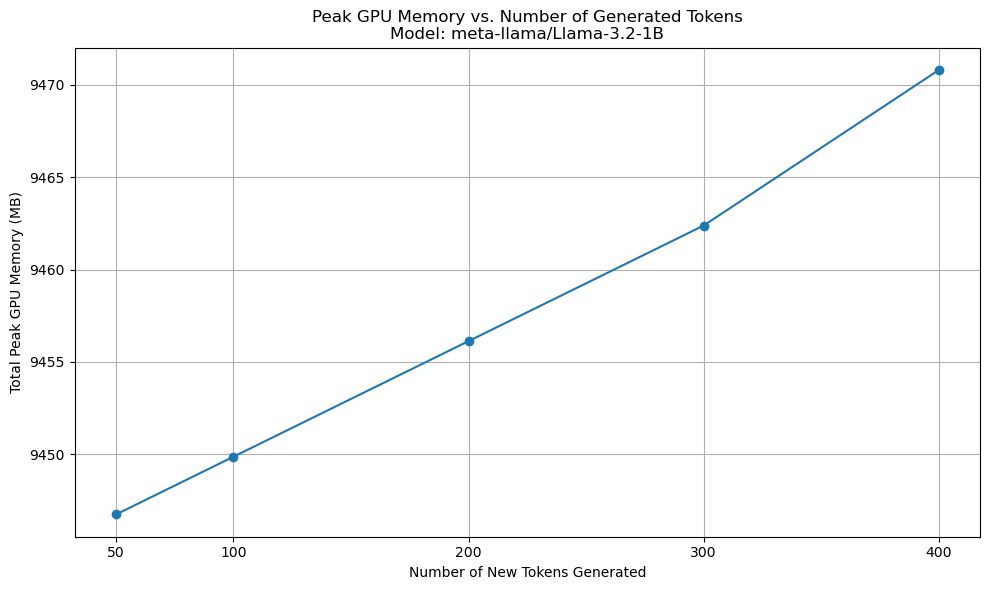

In [7]:
print("--- Results Summary ---")
print("Generated Tokens | Total Peak Memory (MB)")
print("-----------------|------------------------")
for i, length in enumerate(generation_lengths):
    mem_val = peak_memory_results_mb[i]
    print(f"{length:16} | {mem_val:22.2f}")

# Plotting the results
if device == "cuda" and peak_memory_results_mb:
    plt.figure(figsize=(10, 6))
    plt.plot(generation_lengths, peak_memory_results_mb, marker='o', linestyle='-')
    plt.title(f'Peak GPU Memory vs. Number of Generated Tokens\nModel: {model_name}')
    plt.xlabel('Number of New Tokens Generated')
    plt.ylabel('Total Peak GPU Memory (MB)')
    plt.grid(True)
    plt.xticks(generation_lengths)
    plt.tight_layout()
    plt.savefig("kv_cache_memory_growth.png")
    print("\nPlot saved to kv_cache_memory_growth.png")
    plt.show()

## Step 5: Interpretation and Conclusion

The results clearly show a **linear relationship** between the number of generated tokens and the peak GPU memory usage.

- **Baseline Memory:** The initial memory consumed after loading the model is the cost of storing the model's weights themselves.
- **Memory Growth:** The subsequent increase in memory with each generation run is almost entirely due to the **KV Cache**. For every new token generated, its corresponding Key and Value vectors are computed and stored in the cache for all attention heads across all layers.

### Calculating Memory per Token

We can estimate the memory cost per token by looking at the slope of our graph. Let's calculate it between the first and last data points:

In [9]:
if len(peak_memory_results_mb) > 1:
    delta_memory = peak_memory_results_mb[-1] - peak_memory_results_mb[0]
    delta_tokens = generation_lengths[-1] - generation_lengths[0]
    memory_per_token = delta_memory / delta_tokens
    print(f"Estimated memory growth per token: {memory_per_token:.2f} MB/token")


Estimated memory growth per token: 0.07 MB/token


### Final Takeaway

This exercise empirically proves the memory cost of KV Caching. While it's essential for fast inference, it's also a primary constraint on the maximum sequence length a model can handle on a given GPU. This is why techniques like **Grouped-Query Attention (GQA)**, which we'll cover next, were developed—to reduce the size of the KV Cache and mitigate this exact problem.